In [1]:
import os.path as op
import scipy.io
import numpy as np
import mne
from mne.viz import plot_topomap
import matplotlib.pyplot as plt
from mne.channels import find_ch_adjacency
from mne.stats import permutation_cluster_1samp_test, ttest_1samp_no_p
from functools import partial
import seaborn as sns
import json

In [2]:
ages = ['three','six','twelve'] 

file_paths = {
    'three':'processed_psd_three.mat',
    'six':'processed_psd_six.mat',
    'twelve': 'processed_psd_twelve.mat'
}

montage = mne.channels.read_custom_montage('/home/bonaiuto/devmobeta/devmobeta_grasp/analysis/preprocessing/GSN-HydroCel-129.sfp')

info = mne.create_info(montage.ch_names, 500, 'eeg').set_montage(montage)
info_128 = mne.pick_info(info, np.arange(129))

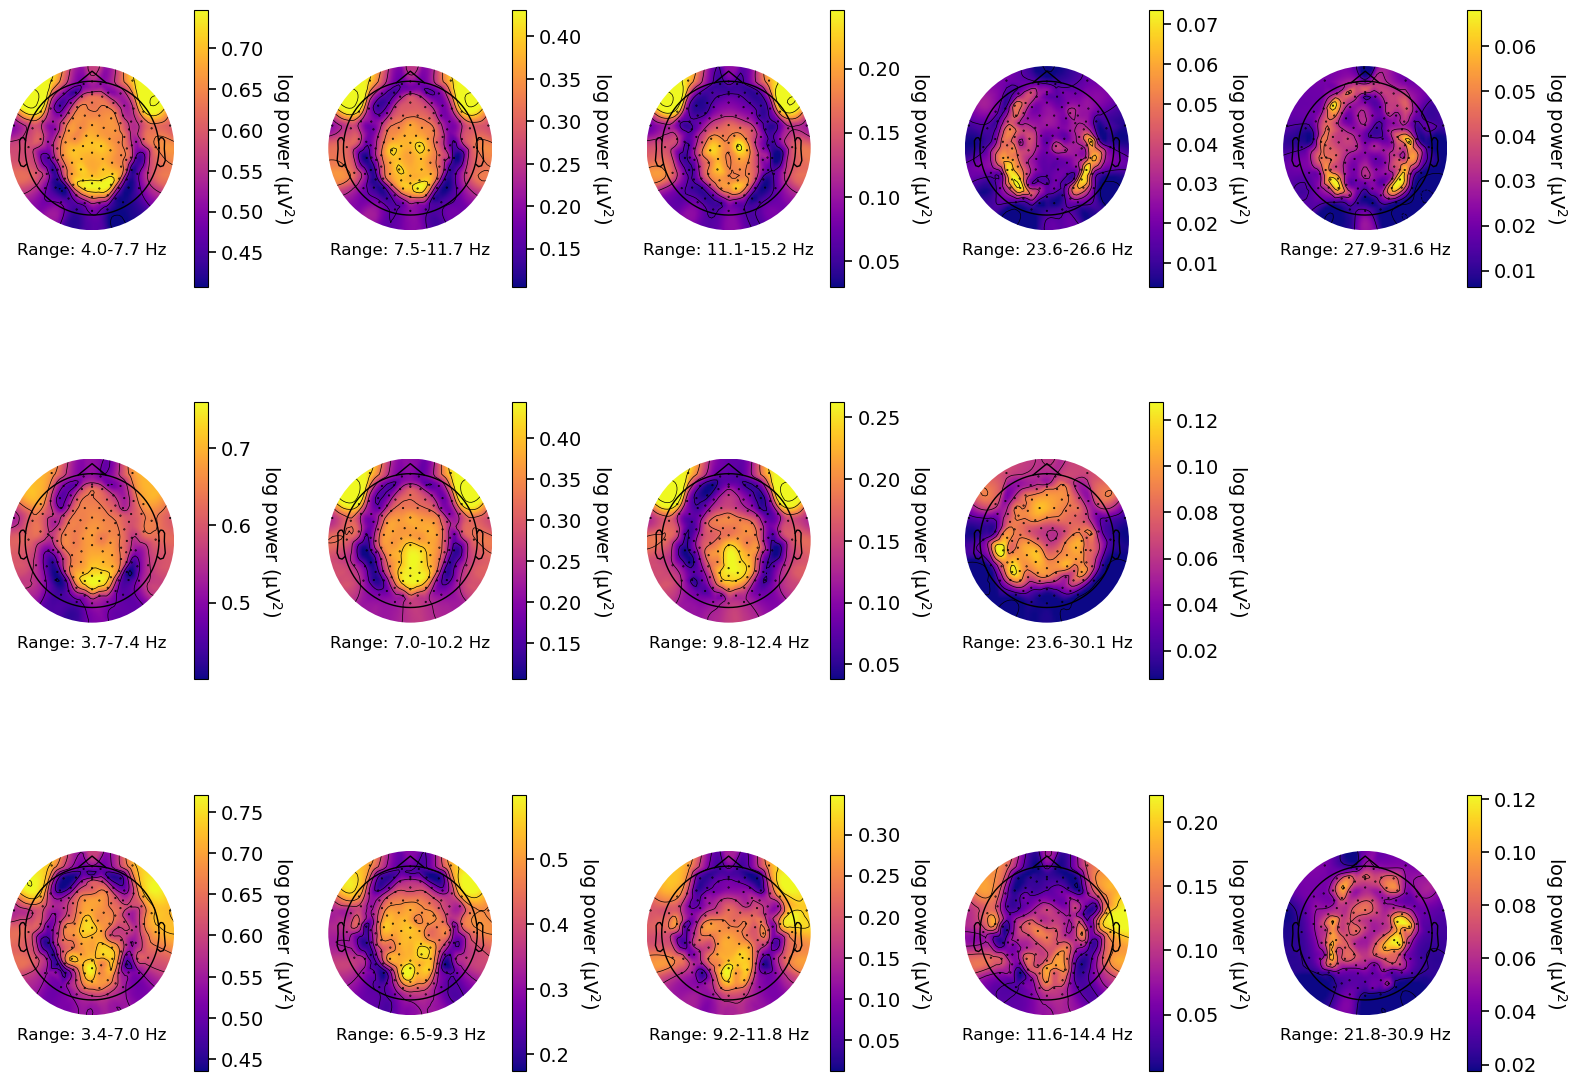

In [4]:
color_ranges = {
     'three': [
       [ 4.05,  7.65],
       [ 7.45, 11.65],
       [11.05, 15.25],
       [23.55, 26.65],
       [27.85, 31.55],
    ],
    'six': [
       [ 3.7 ,  7.4 ],
       [ 7.  , 10.2 ],
       [ 9.75, 12.45],
       [23.65, 30.15]
    ],
    'twelve': [
       [ 3.35,  6.95],
       [ 6.5 ,  9.3 ],
       [ 9.25, 11.75],
       [11.6 , 14.4 ],
       [21.8 , 30.9 ],
    ]
}

fig = plt.figure(figsize=(16, 12), facecolor='w')
gs = fig.add_gridspec(len(ages), 5) 

plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})


for age_idx, age in enumerate(ages):
    fname = file_paths[age] 
    data = scipy.io.loadmat(fname)  
    periodic = data['periodic'] 
    periodic[periodic < 0] = 0 
    frex = data['frex'][0, :] 
    fois = data['foi_ranges'] 
    
    for range_idx, color_range in enumerate(color_ranges[age]):
        frex_idx = np.where((frex >= color_range[0]) & (frex <= color_range[1]))[0]
        
        mean_range = np.nanmean(np.nanmean(periodic[:, :, frex_idx], axis=2), axis=0)
        
        ax = fig.add_subplot(gs[age_idx, range_idx])
        
        mean_range = mean_range.ravel() 
        
        tm, cm = mne.viz.plot_topomap(
            mean_range, info_128, cmap='plasma', axes=ax, show=False,
            contours=5, vlim=(np.min(mean_range), np.max(mean_range)),outlines='head',
            sphere=.1
        )
        
        ax.text(0.5, -0.15, f'Range: {color_range[0]:.1f}-{color_range[1]:.1f} Hz', 
                horizontalalignment='center', transform=ax.transAxes, fontsize=12)
        
        cbar = plt.colorbar(tm, fraction=0.07, pad=0.10)
        cbar.set_label('log power (µV$^2$)', rotation=270, labelpad=23)

plt.tight_layout()
plt.show()


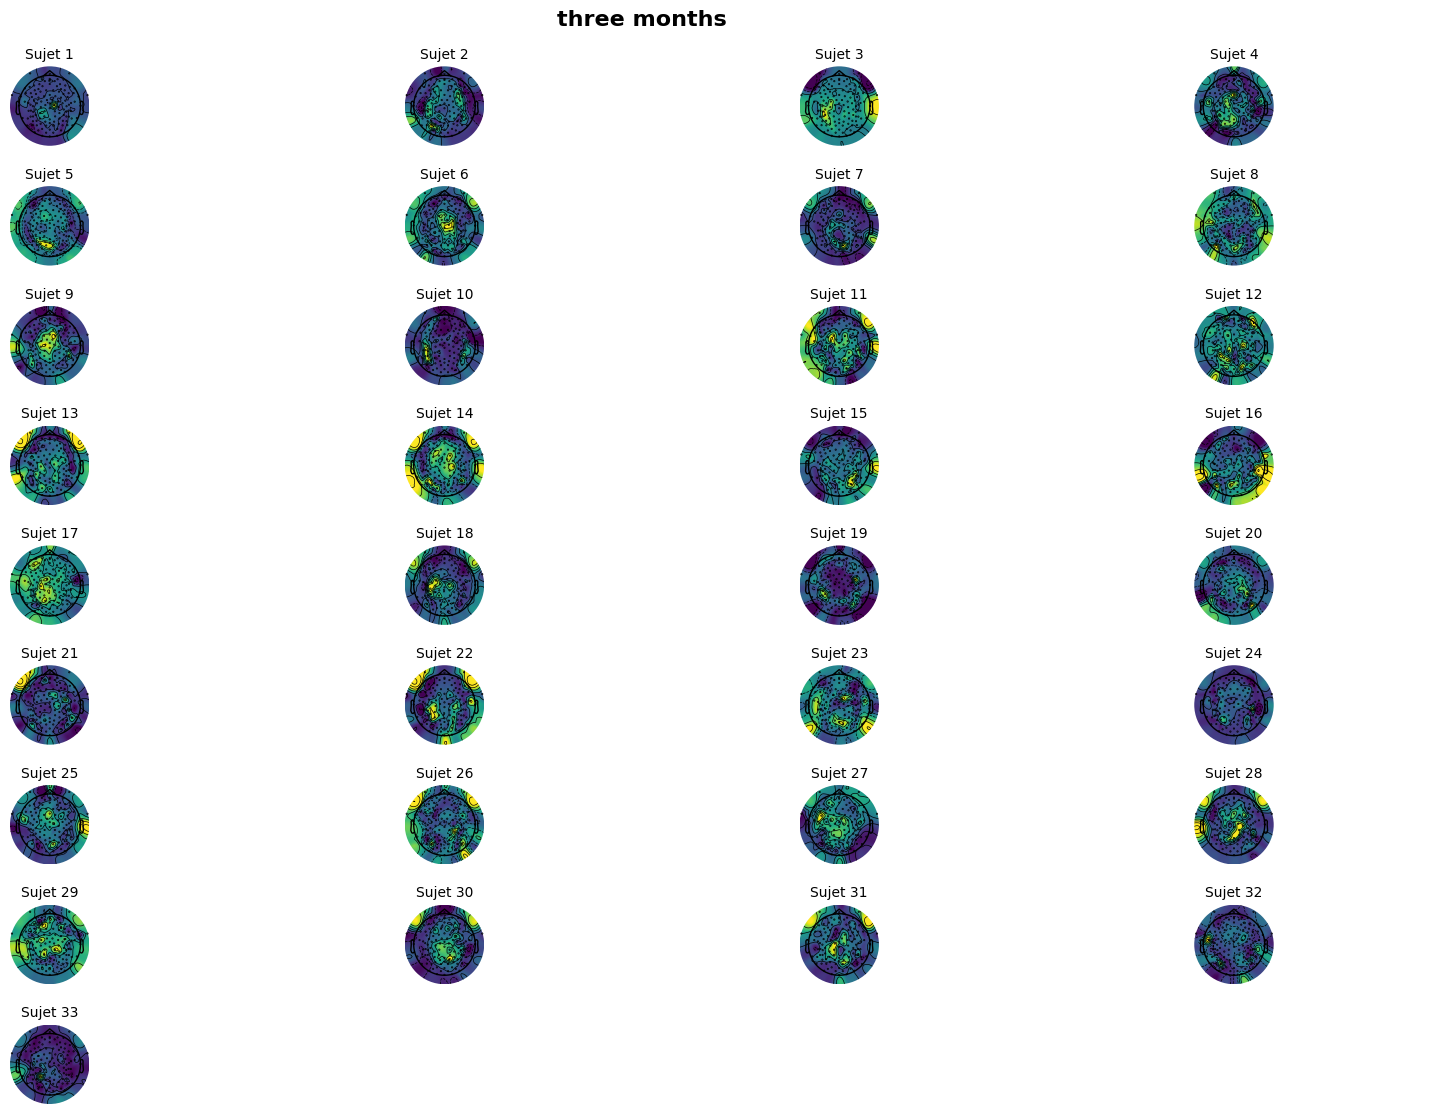

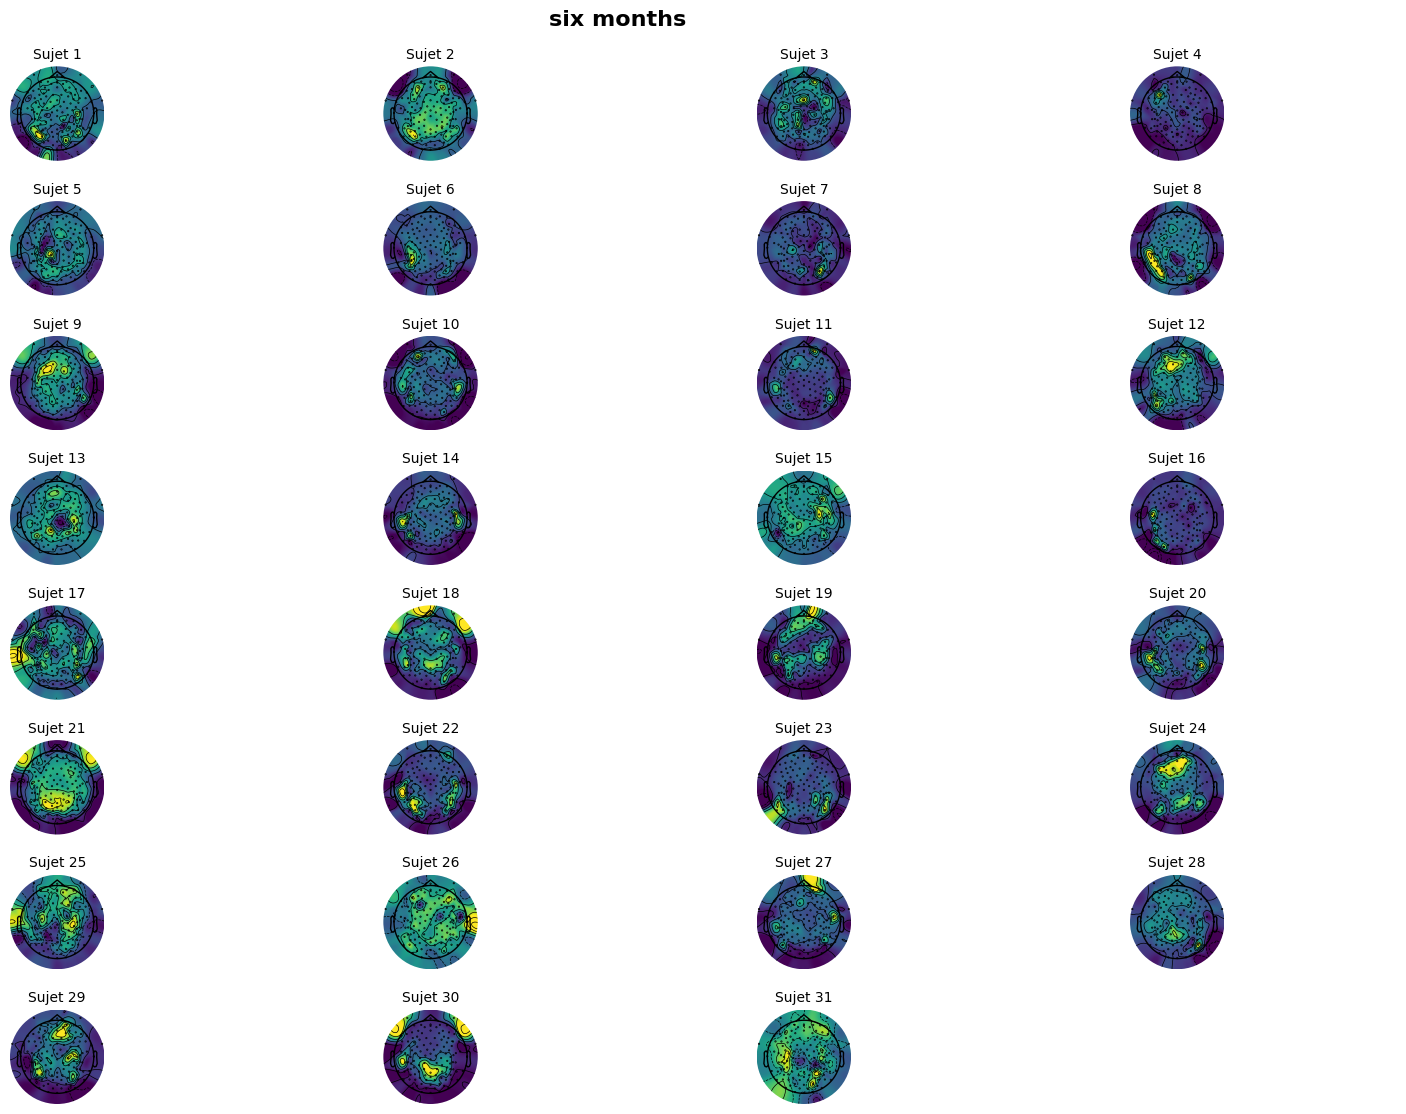

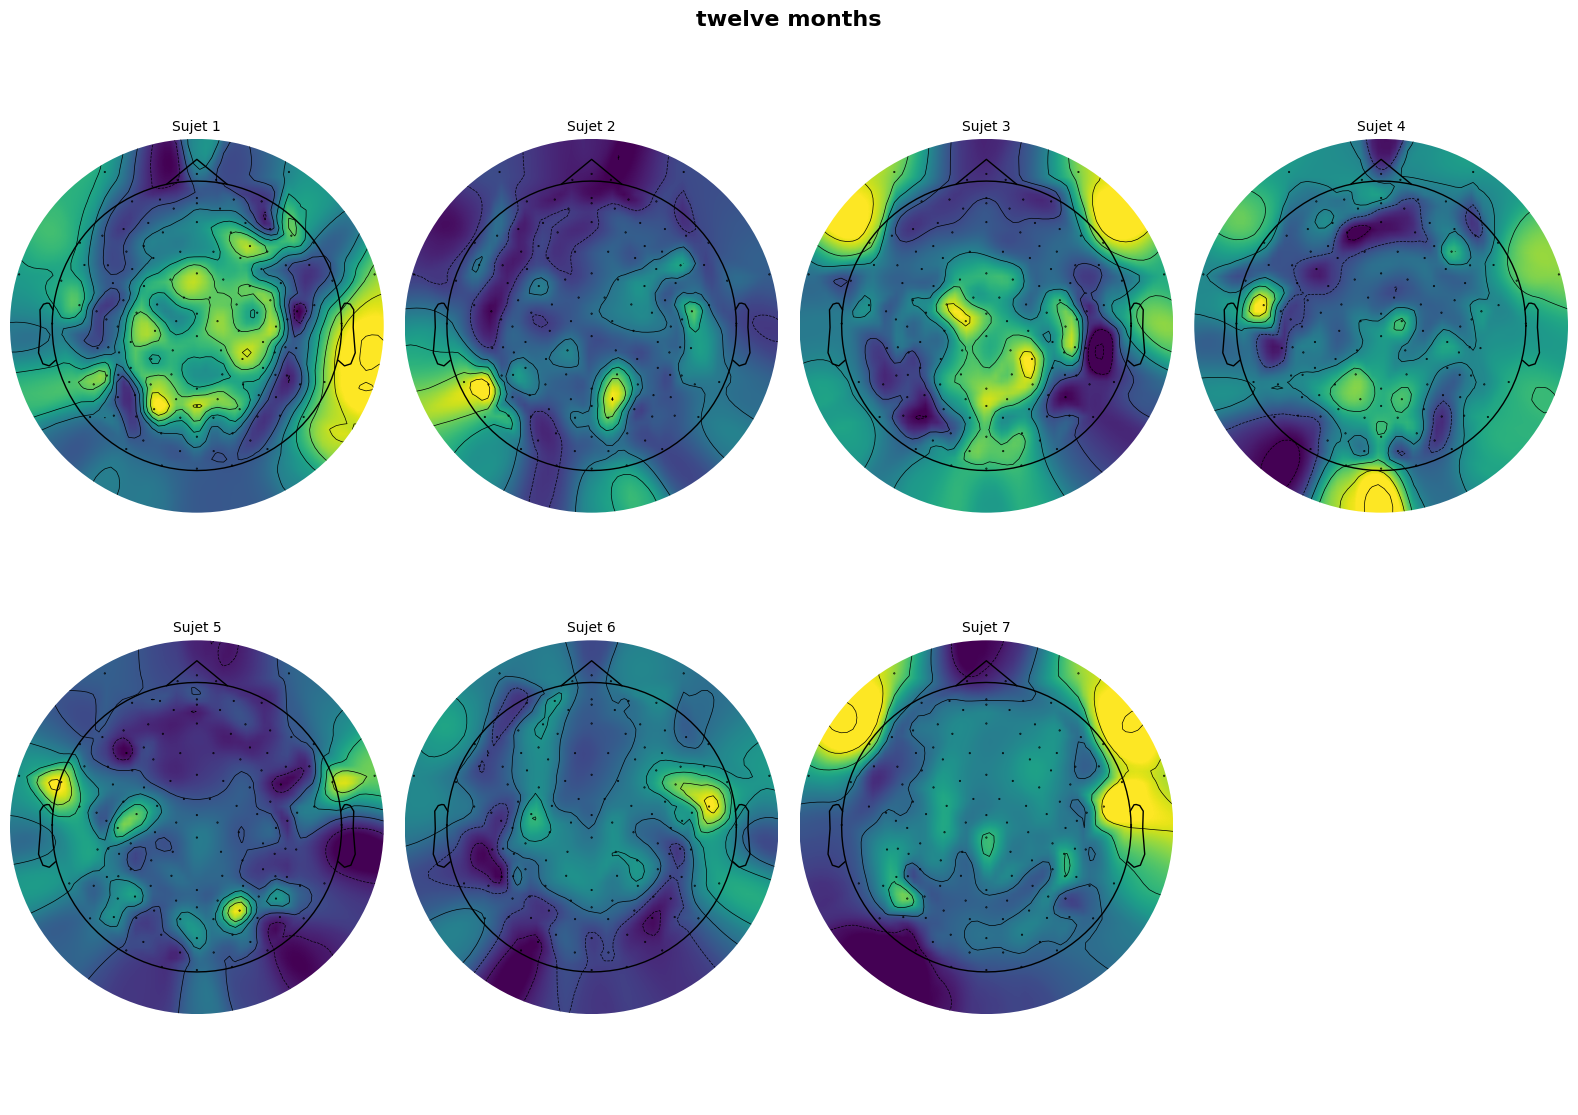

In [50]:
info_63 = mne.pick_info(info, np.arange(129))

age_intervals = {
    'three':[15.1, 19.8],
    'six': [24.15,30.75],
    'twelve': [13.55, 16.35]
}

for age_idx, age in enumerate(ages):
    fname = file_paths[age]  
    data = scipy.io.loadmat(fname)
    psd = data['periodic']  
    frex = data['frex'][0, :]  
    subjects = psd.shape[0]  

    beta_range = age_intervals[age]
    frex_idx = np.where((frex >= beta_range[0]) & (frex <= beta_range[1]))[0]
    
    fig, axes = plt.subplots(nrows=int(np.ceil(subjects / 4)), ncols=4, figsize=(16, 12))
    fig.suptitle(f'{age} months', fontsize=16, fontweight='bold')

    axes = axes.flatten()  

    for subj_idx in range(subjects):
        subject_psd = psd[subj_idx]  
        
        if subject_psd.ndim == 3:  
            subject_psd = np.nanmean(subject_psd, axis=0)  
        
        elif subject_psd.ndim == 2 and subject_psd.shape[0] == 801:  
            subject_psd = subject_psd.T  

        elif subject_psd.ndim == 1:  
            raise ValueError(f"Les données du sujet {subj_idx} ne contiennent qu'une seule dimension : {subject_psd.shape}")

        mean_beta = np.nanmean(subject_psd[:, frex_idx], axis=1).ravel()  # (63,)

        ax = axes[subj_idx] if subj_idx < len(axes) else None
        if ax:
            im, _ = mne.viz.plot_topomap(
                mean_beta, info_63, cmap='viridis', axes=ax, show=False,
                contours=6, vlim=(np.min(mean_beta), np.max(mean_beta))
            )
            ax.set_title(f'Sujet {subj_idx + 1}', fontsize=10)  

  
    for ax_idx in range(subjects, len(axes)):
        axes[ax_idx].axis('off')
    plt.tight_layout(rect=[0, 0.05, 1, 1]) 
    plt.show()
